# CIFAR-10 Calibration Shift Detection

**Problem:** A pretrained classifier is deployed on CIFAR-10 test images. After some time, the input distribution shifts to CIFAR-10-C (corrupted images). The model continues to produce confidence scores, but they no longer reflect true accuracy—the model is *miscalibrated*.

**Solution:** PITMonitor watches the model's predicted probabilities against true labels in real-time. It detects when the probability integral transform (PIT) values deviate from uniformity, triggering an alarm without needing manual thresholds or labels ahead of time.

**This Demo:** We train an MLP classifier on CIFAR-10, then stream it CIFAR-10-C-corrupted images. PITMonitor detects the miscalibration shift and fires an alarm.

### Imports & Config

In [44]:
import pickle
import warnings
import time as timer
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from pitmon import PITMonitor

In [ ]:
# Configuration Constants
SEED = 0
DATA_DIR = Path("./data")

# Demo 1: Single Detection Parameters
TRAIN_SIZE = 15_000
N_STABLE = 300
N_SHIFTED = 300
CORRUPTION = "gaussian_noise"
SEVERITY = 3

# PITMonitor Parameters
ALPHA = 0.05
N_BINS = 10

# Demo 2: Power Analysis Parameters
ALPHA_POWER = 0.05
N_STABLE_POWER = 300
N_SHIFTED_POWER = 300
N_TRIALS_H0_PER_SEVERITY = 1_000
N_TRIALS_H1_PER_SEVERITY = 1_000
SEVERITY_LEVELS = [1, 2, 3, 4, 5]

# Initialize RNG
rng = np.random.default_rng(SEED)

In [46]:
VERBOSE_DEMO = True


def log(message: str = "") -> None:
    if VERBOSE_DEMO:
        print(message)

### Helper Functions

In [47]:
@dataclass
class DetectionResult:
    alarm_fired: bool
    alarm_time: int | None
    detection_delay: int | None
    final_evidence: float


def _load_cifar_batch(batch_file: Path) -> tuple[np.ndarray, np.ndarray]:
    with open(batch_file, "rb") as f:
        payload = pickle.load(f, encoding="bytes")
    x = payload[b"data"]
    y = np.array(payload[b"labels"], dtype=np.int64)
    return x, y


def load_cifar10_train_test(
    data_dir: Path,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Load CIFAR-10 training and test sets."""
    root = data_dir / "CIFAR-10"
    if not root.exists():
        raise FileNotFoundError(f"Missing CIFAR-10 directory: {root}")

    x_train_all, y_train_all = [], []
    for i in range(1, 6):
        x_i, y_i = _load_cifar_batch(root / f"data_batch_{i}")
        x_train_all.append(x_i)
        y_train_all.append(y_i)

    x_train = np.vstack(x_train_all).astype(np.float32) / 255.0
    y_train = np.concatenate(y_train_all)
    x_test, y_test = _load_cifar_batch(root / "test_batch")
    x_test = x_test.astype(np.float32) / 255.0
    return x_train, y_train, x_test, y_test


def load_cifar10c_corruption(
    data_dir: Path, corruption: str, severity: int
) -> tuple[np.ndarray, np.ndarray]:
    """Load CIFAR-10-C corrupted images for a specific corruption type and severity."""
    if not 1 <= severity <= 5:
        raise ValueError("severity must be in {1,2,3,4,5}")

    root = data_dir / "CIFAR-10-C"
    if not root.exists():
        raise FileNotFoundError(f"Missing CIFAR-10-C directory: {root}")

    x_all = np.load(root / f"{corruption}.npy")
    y_all = np.load(root / "labels.npy")

    n_per_severity = 10_000
    start = (severity - 1) * n_per_severity
    end = severity * n_per_severity
    x = x_all[start:end].reshape(n_per_severity, -1).astype(np.float32) / 255.0
    y = y_all[start:end].astype(np.int64)
    return x, y


def sanitize_probabilities(probs: np.ndarray) -> np.ndarray:
    """Clean invalid probability values and ensure proper distribution."""
    probs = np.array(probs, dtype=np.float64, copy=True)
    probs = np.nan_to_num(probs, nan=0.0, posinf=0.0, neginf=0.0)

    row_sums = probs.sum(axis=1, keepdims=True)
    invalid_rows = ~np.isfinite(row_sums[:, 0]) | (row_sums[:, 0] <= 0.0)
    if np.any(invalid_rows):
        probs[invalid_rows] = 1.0 / probs.shape[1]
        row_sums = probs.sum(axis=1, keepdims=True)

    probs /= row_sums
    return probs.astype(np.float32)


def predict_proba_safe(
    clf: MLPClassifier, x: np.ndarray, scaler: StandardScaler
) -> np.ndarray:
    """Get predicted probabilities with safety checks."""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        probs = clf.predict_proba(scaler.transform(x))
    return sanitize_probabilities(probs)


def build_true_prob_reference(probs: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    """Build an order-invariant clean reference of true-class probabilities."""
    probs = np.asarray(probs, dtype=np.float32)
    y_true = np.asarray(y_true, dtype=np.int64)
    idx = np.arange(len(y_true))
    p_true = np.clip(probs[idx, y_true], 0.0, 1.0)
    return np.sort(p_true.astype(np.float32, copy=False))


def confidence_pits_from_reference(
    probs: np.ndarray,
    y_true: np.ndarray,
    reference_sorted: np.ndarray,
    rng: np.random.Generator,
) -> np.ndarray:
    """Randomized empirical-CDF PIT on true-class confidence, tied to clean reference."""
    probs = np.asarray(probs, dtype=np.float32)
    y_true = np.asarray(y_true, dtype=np.int64)
    ref = np.asarray(reference_sorted, dtype=np.float32)

    if ref.ndim != 1 or len(ref) == 0:
        raise ValueError("reference_sorted must be a non-empty 1D array")

    idx = np.arange(len(y_true))
    p_true = np.clip(probs[idx, y_true], 0.0, 1.0)

    left = np.searchsorted(ref, p_true, side="left")
    right = np.searchsorted(ref, p_true, side="right")
    u = rng.random(len(y_true), dtype=np.float32)

    pits = (left + u * (right - left)) / float(len(ref))
    return np.clip(pits, 0.0, 1.0).astype(np.float32, copy=False)


def compute_classification_pits(
    probs: np.ndarray, y_true: np.ndarray, rng: np.random.Generator
) -> np.ndarray:
    """Legacy class-index PIT (kept for compatibility)."""
    probs = np.asarray(probs, dtype=np.float32)
    y_true = np.asarray(y_true, dtype=np.int64)
    n_samples = y_true.shape[0]

    u = rng.random(n_samples, dtype=np.float32)
    cdf = np.cumsum(probs, axis=1, dtype=np.float32)

    left_mass = np.zeros(n_samples, dtype=np.float32)
    nonzero = y_true > 0
    left_mass[nonzero] = cdf[np.arange(n_samples)[nonzero], y_true[nonzero] - 1]

    true_mass = probs[np.arange(n_samples), y_true]
    pits = left_mass + u * true_mass
    return np.clip(pits, 0.0, 1.0).astype(np.float32, copy=False)

In [33]:
def run_pitmon_session(
    pits: np.ndarray,
    alpha: float,
    n_bins: int,
    n_stable: int,
) -> tuple[DetectionResult, np.ndarray, PITMonitor]:
    """Run PITMonitor on PIT stream and collect evidence trace."""
    monitor = PITMonitor(alpha=alpha, n_bins=n_bins)
    evidence_trace = np.empty(len(pits), dtype=float)

    for i, pit in enumerate(pits):
        update = monitor.update(pit)
        evidence_trace[i] = update.evidence

    alarm_time = monitor.alarm_time
    detection_delay = None
    if alarm_time is not None and alarm_time > n_stable:
        detection_delay = alarm_time - n_stable

    return (
        DetectionResult(
            alarm_fired=monitor.alarm_triggered,
            alarm_time=alarm_time,
            detection_delay=detection_delay,
            final_evidence=monitor.evidence,
        ),
        evidence_trace,
        monitor,
    )

In [34]:
def plot_pitmon_results(
    pred_labels: np.ndarray,
    true_labels: np.ndarray,
    pits: np.ndarray,
    evidence_trace: np.ndarray,
    true_shift_point: int,
    result: DetectionResult,
    monitor: PITMonitor,
    alpha: float,
    title: str,
) -> None:
    """Visualize PITMonitor detection results with 4 panels, using monitor's changepoint estimate."""
    t = np.arange(1, len(pits) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    fig.suptitle(title, fontsize=13, fontweight="bold")

    # Panel 1: Predicted classes colored by correctness
    ax = axes[0, 0]
    is_correct = pred_labels == true_labels
    point_colors = np.where(is_correct, "darkgreen", "crimson")
    ax.scatter(
        t,
        pred_labels,
        s=9,
        alpha=0.5,
        c=point_colors,
        label="Prediction (green=correct, red=wrong)",
        zorder=2,
    )

    ax.axvline(
        true_shift_point,
        color="red",
        ls=":",
        lw=1.5,
        alpha=0.8,
        label=f"True shift (t={true_shift_point})",
    )
    if result.alarm_fired and result.alarm_time is not None:
        ax.axvline(
            result.alarm_time,
            color="orange",
            ls="--",
            lw=1.5,
            label=f"Alarm (t={result.alarm_time})",
        )
    ax.set_ylabel("Predicted class", fontsize=11)
    ax.set_title("Predictions (Correct vs Wrong)", fontsize=11, fontweight="bold")
    ax.set_ylim(-0.5, 9.5)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)
    ax.set_xlim(left=0, right=len(t))

    # Panel 2: PIT scatter with rolling mean
    ax = axes[0, 1]
    colors = np.where(t <= true_shift_point, "steelblue", "crimson")
    ax.scatter(t, pits, s=5, alpha=0.4, c=colors)

    rolling_pit = np.convolve(pits, np.ones(30) / 30, mode="valid")
    ax.plot(
        np.arange(30, len(pits) + 1),
        rolling_pit,
        color="black",
        lw=1.5,
        alpha=0.6,
        label="Rolling mean (w=30)",
    )
    ax.axhline(0.5, color="gray", ls="--", lw=1, alpha=0.4)
    ax.axvline(true_shift_point, color="red", ls=":", lw=1.5, alpha=0.8)
    if result.alarm_fired and result.alarm_time is not None:
        ax.axvline(result.alarm_time, color="orange", ls="--", lw=1.5)
    ax.set_ylabel("PIT value", fontsize=11)
    ax.set_title("PIT Stream", fontsize=11, fontweight="bold")
    ax.set_ylim(-0.05, 1.05)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)
    ax.set_xlim(left=0, right=len(t))

    # Panel 3: Log-evidence trace with PITMonitor's changepoint
    ax = axes[1, 0]
    ax.semilogy(t, np.maximum(evidence_trace, 1e-10), color="steelblue", lw=2)
    threshold = 1 / alpha
    ax.axhline(
        threshold,
        color="crimson",
        ls="--",
        lw=2,
        label=f"Threshold (1/α = {threshold:.0f})",
    )
    ax.axvline(
        true_shift_point, color="red", ls=":", lw=1.5, alpha=0.8, label="True shift"
    )

    # Use PITMonitor's built-in changepoint estimate
    try:
        summary = monitor.summary()
        est_cp = summary.get("changepoint")
        if est_cp:
            ax.axvline(
                est_cp,
                color="green",
                ls="--",
                lw=1.5,
                alpha=0.7,
                label=f"Est. changepoint (t≈{est_cp})",
            )
    except:
        pass  # Fallback if summary not available

    if result.alarm_fired and result.alarm_time is not None:
        ax.axvline(
            result.alarm_time,
            color="orange",
            ls="--",
            lw=2,
            label=f"Alarm (t={result.alarm_time})",
        )
    ax.set_ylabel("Log-evidence", fontsize=11)
    ax.set_xlabel("Observation", fontsize=11)
    ax.set_title("PITMonitor Evidence", fontsize=11, fontweight="bold")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2, which="both")
    ax.set_xlim(left=0, right=len(t))

    # Panel 4: PIT distributions
    ax = axes[1, 1]
    hist_bins = np.linspace(0, 1, 21)
    ax.hist(
        pits[: true_shift_point - 1],
        bins=hist_bins,
        density=True,
        alpha=0.5,
        color="steelblue",
        edgecolor="white",
        label="Pre-shift",
    )
    ax.hist(
        pits[true_shift_point - 1 :],
        bins=hist_bins,
        density=True,
        alpha=0.5,
        color="crimson",
        edgecolor="white",
        label="Post-shift",
    )
    ax.axhline(1.0, color="black", ls="--", lw=1.5, label="Ideal (Uniform)")
    ax.set_xlabel("PIT value", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.set_title("PIT Distributions", fontsize=11, fontweight="bold")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

## Demo 1: Single Detection Run

Track a classifier as its input distribution shifts from clean CIFAR-10 to corrupted CIFAR-10-C.

#### Step 1: Load Data

In [48]:
log("Step 1: Load CIFAR-10 and CIFAR-10-C")

x_train, y_train, x_test, y_test = load_cifar10_train_test(DATA_DIR)
x_corr, y_corr = load_cifar10c_corruption(DATA_DIR, CORRUPTION, SEVERITY)

log(f"CIFAR-10 train: {x_train.shape}")
log(f"CIFAR-10 test: {x_test.shape}")
log(f"CIFAR-10-C: {x_corr.shape} (corruption={CORRUPTION}, severity={SEVERITY})")

# Validation
if TRAIN_SIZE > len(x_train):
    raise ValueError(f"TRAIN_SIZE={TRAIN_SIZE} exceeds available {len(x_train)}")
if N_STABLE > len(x_test):
    raise ValueError(f"N_STABLE={N_STABLE} exceeds test set {len(x_test)}")
if N_SHIFTED > len(x_corr):
    raise ValueError(f"N_SHIFTED={N_SHIFTED} exceeds corrupted {len(x_corr)}")

# Sample subsets
train_idx = rng.choice(len(x_train), size=TRAIN_SIZE, replace=False)
x_train_sub = x_train[train_idx]
y_train_sub = y_train[train_idx]

stable_idx = rng.choice(len(x_test), size=N_STABLE, replace=False)
shifted_idx = rng.choice(len(x_corr), size=N_SHIFTED, replace=False)
x_stable = x_test[stable_idx]
y_stable = y_test[stable_idx]
x_shifted = x_corr[shifted_idx]
y_shifted = y_corr[shifted_idx]

log(
    f"Config | train={TRAIN_SIZE:,}, stable={N_STABLE:,}, shifted={N_SHIFTED:,}, "
    f"alpha={ALPHA}, bins={N_BINS}"
)

Step 1: Load CIFAR-10 and CIFAR-10-C
CIFAR-10 train: (50000, 3072)
CIFAR-10 test: (10000, 3072)
CIFAR-10-C: (10000, 3072) (corruption=gaussian_noise, severity=3)
Config | train=15,000, stable=300, shifted=300, alpha=0.05, bins=10


#### Step 2: Train Model

In [36]:
log("Step 2: Train neural network on CIFAR-10")

scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train_sub)

clf = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=800,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=SEED,
    learning_rate_init=0.001,
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(x_train_s, y_train_sub)

train_acc = clf.score(x_train_s, y_train_sub)
log(f"Training accuracy: {train_acc:.4f}")

Step 2: Train neural network on CIFAR-10
Training accuracy: 0.6580


#### Step 3: Run Detection

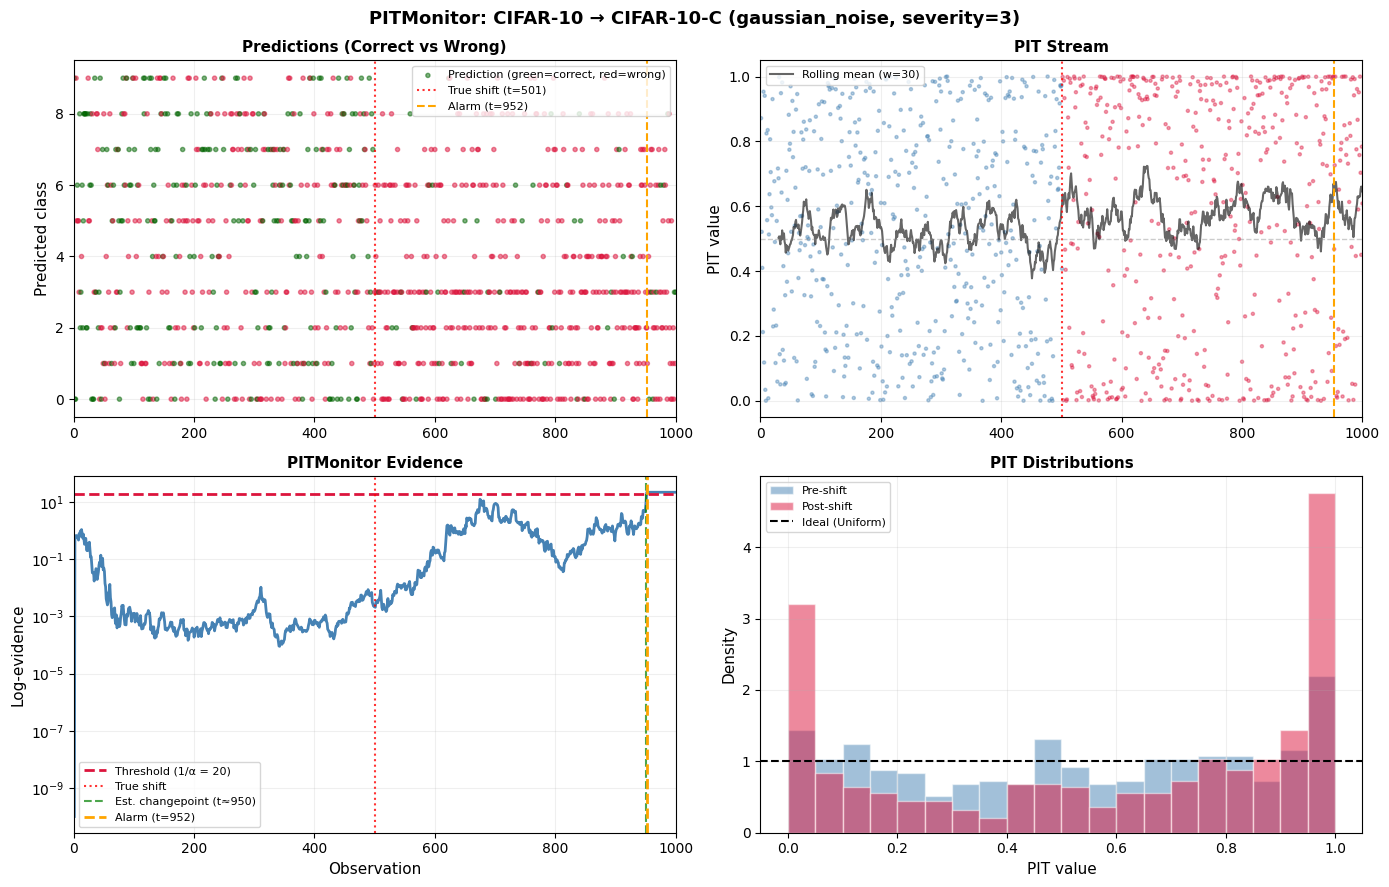

In [ ]:
# Combine stable + shifted streams
x_stream = np.vstack([x_stable, x_shifted])
y_stream = np.concatenate([y_stable, y_shifted])
true_shift_point = N_STABLE + 1

# Get predictions
probs = clf.predict_proba(scaler.transform(x_stream))
pred = probs.argmax(axis=1)

# Compute PITs using class-index formula (standard discrete PIT for classification)
rng_demo = np.random.default_rng(SEED)
pits = compute_classification_pits(probs, y_stream, rng_demo)

# Run PITMonitor
result, evidence_trace, monitor = run_pitmon_session(pits, ALPHA, N_BINS, N_STABLE)

# Visualize
plot_pitmon_results(
    pred,
    y_stream,
    pits,
    evidence_trace,
    true_shift_point,
    result,
    monitor,
    ALPHA,
    f"PITMonitor: CIFAR-10 → CIFAR-10-C ({CORRUPTION}, severity={SEVERITY})",
)

## Demo 2: Power Analysis

Evaluate PITMonitor's detection reliability across corruption severity levels:
- **H₀ Validation:** False Positive Rate control (clean → clean)
- **H₁ Power:** True Positive Rate vs corruption severity (clean → corrupted)
- **Detection Latency:** Time to alarm across severity levels

In [49]:
def summarize_power_trials(trials: list[dict], n_trials: int) -> dict:
    """Aggregate trial-level monitoring results into power statistics."""
    n_alarms = sum(t["alarm_fired"] for t in trials)
    n_false = sum(t["false_alarm"] for t in trials)
    n_detect = sum(1 for t in trials if t["alarm_fired"] and not t["false_alarm"])
    alarm_rate = n_alarms / n_trials
    false_rate = n_false / n_trials
    tpr = n_detect / n_trials

    delays = [t["detection_delay"] for t in trials if t["detection_delay"] is not None]
    median_delay = np.median(delays) if delays else float("nan")
    mean_delay = np.mean(delays) if delays else float("nan")

    def wilson_ci(k: int, n: int, z: float = 1.96) -> tuple[float, float]:
        if n <= 0:
            return float("nan"), float("nan")
        p_hat = k / n
        denom = 1 + z**2 / n
        center = (p_hat + z**2 / (2 * n)) / denom
        radius = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n)) / n) / denom
        return float(max(0.0, center - radius)), float(min(1.0, center + radius))

    tpr_ci_low, tpr_ci_high = wilson_ci(n_detect, n_trials)
    fpr_ci_low, fpr_ci_high = wilson_ci(n_false, n_trials)

    return {
        "n_trials": n_trials,
        "n_alarms": n_alarms,
        "n_false": n_false,
        "n_detect": n_detect,
        "alarm_rate": alarm_rate,
        "false_alarm_rate": false_rate,
        "tpr": tpr,
        "tpr_ci_low": tpr_ci_low,
        "tpr_ci_high": tpr_ci_high,
        "fpr_ci_low": fpr_ci_low,
        "fpr_ci_high": fpr_ci_high,
        "median_delay": median_delay,
        "mean_delay": mean_delay,
        "delays": delays,
        "evidences": [t["final_evidence"] for t in trials],
    }


def run_power_trial(
    clf_trained,
    scaler_trained,
    x_stable,
    y_stable,
    x_shifted,
    y_shifted,
    pit_reference_sorted: np.ndarray,
    alpha: float = 0.05,
    n_bins: int = 10,
    trial_seed: int = None,
) -> dict:
    """
    Run one CIFAR monitoring trial using a pre-trained classifier.

    Parameters
    ----------
    clf_trained : MLPClassifier
        Pre-trained classifier to use for predictions
    scaler_trained : StandardScaler
        Pre-fitted scaler matching the classifier
    pit_reference_sorted : np.ndarray
        Sorted true-class confidence reference from clean calibration data

    Returns
    -------
    dict
        Standard trial summary from PITMonitor's built-in trial_summary method.
    """
    x_all = np.vstack([x_stable, x_shifted])
    y_all = np.concatenate([y_stable, y_shifted])
    n_stable_local = len(y_stable)

    probs = predict_proba_safe(clf_trained, x_all, scaler_trained)

    rng_trial = np.random.default_rng(trial_seed)
    pits = confidence_pits_from_reference(probs, y_all, pit_reference_sorted, rng_trial)

    monitor = PITMonitor(alpha=alpha, n_bins=n_bins)
    monitor.update_many(pits, stop_on_alarm=True)

    return monitor.trial_summary(n_stable_local)

In [61]:
from concurrent.futures import ThreadPoolExecutor
import os

os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")

required_names = ["x_train_sub", "y_train_sub", "x_test", "y_test"]
missing = [name for name in required_names if name not in globals()]
if missing:
    raise RuntimeError(
        "Missing required variables for Part 2. Run Cells 12-14 first. Missing: "
        + ", ".join(missing)
    )

log("Power analysis: H₀ validation + H₁ detection rate")
log("Evaluating FPR control and TPR across corruption severities")

max_workers_default = min(8, max(1, (os.cpu_count() or 4) - 1))
MAX_WORKERS_POWER = int(os.getenv("PITMON_MAX_WORKERS", max_workers_default))
MAX_WORKERS_POWER = max(1, min(32, MAX_WORKERS_POWER))

log("Phase 1: H₀ validation (clean → clean)")

h0_results_by_severity = {}
t0_global = timer.time()

# H₀: Train ONE classifier on clean CIFAR-10, then evaluate on independent test splits
# This eliminates network randomness as a source of false alarms
log("Training baseline classifier for H₀ validation...")
sc_h0 = StandardScaler()
x_train_s = sc_h0.fit_transform(x_train_sub)

clf_h0 = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=800,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=SEED,
    learning_rate_init=0.001,
)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf_h0.fit(x_train_s, y_train_sub)

# Build clean reference for order-invariant confidence PIT
rng_ref = np.random.default_rng(SEED + 40_000)
n_ref_cal = min(2000, len(x_test) // 2)
ref_idx = rng_ref.choice(len(x_test), size=n_ref_cal, replace=False)
probs_ref = predict_proba_safe(clf_h0, x_test[ref_idx], sc_h0).astype(
    np.float32, copy=False
)
pit_cal_reference = build_true_prob_reference(probs_ref, y_test[ref_idx])

test_pool_idx = np.setdiff1d(np.arange(len(x_test)), ref_idx)
if len(test_pool_idx) < max(N_STABLE_POWER, N_SHIFTED_POWER):
    raise RuntimeError(
        "Not enough clean test points after reserving PIT reference set. "
        "Reduce n_ref_cal or trial sample sizes."
    )

# Estimate H₀ independently per severity index (same clean-null process, independent seeds)
for severity_level in SEVERITY_LEVELS:

    def run_h0_trial(trial_idx: int) -> dict:
        base_seed = SEED + severity_level * 1_000_000
        rng_h0 = np.random.default_rng(base_seed + 50_000 + trial_idx)
        stable_idx_h0 = rng_h0.choice(test_pool_idx, size=N_STABLE_POWER, replace=False)
        shifted_idx_h0 = rng_h0.choice(
            test_pool_idx, size=N_SHIFTED_POWER, replace=False
        )

        x_stable_h0 = x_test[stable_idx_h0]
        y_stable_h0 = y_test[stable_idx_h0]
        x_shifted_h0 = x_test[shifted_idx_h0]
        y_shifted_h0 = y_test[shifted_idx_h0]

        x_all = np.vstack([x_stable_h0, x_shifted_h0]).astype(np.float32, copy=False)
        y_all = np.concatenate([y_stable_h0, y_shifted_h0]).astype(np.int64, copy=False)
        n_stable_local = len(y_stable_h0)

        probs = predict_proba_safe(clf_h0, x_all, sc_h0).astype(np.float32, copy=False)
        pits = confidence_pits_from_reference(
            probs,
            y_all,
            pit_cal_reference,
            np.random.default_rng(base_seed + 150_000 + trial_idx),
        )

        monitor = PITMonitor(alpha=ALPHA_POWER, n_bins=N_BINS)
        monitor.update_many(pits, stop_on_alarm=True)

        alarm_fired = monitor.alarm_time is not None
        alarm_time = monitor.alarm_time
        false_alarm = alarm_fired and alarm_time <= n_stable_local
        detection_delay = (
            alarm_time - n_stable_local
            if alarm_fired and alarm_time > n_stable_local
            else None
        )

        return {
            "alarm_fired": alarm_fired,
            "alarm_time": alarm_time,
            "detection_delay": detection_delay,
            "final_evidence": float(monitor.evidence),
            "false_alarm": false_alarm,
        }

    with ThreadPoolExecutor(max_workers=MAX_WORKERS_POWER) as ex:
        h0_trials_sev = list(ex.map(run_h0_trial, range(N_TRIALS_H0_PER_SEVERITY)))

    h0_results_by_severity[severity_level] = summarize_power_trials(
        h0_trials_sev, n_trials=N_TRIALS_H0_PER_SEVERITY
    )

    elapsed = timer.time() - t0_global
    result = h0_results_by_severity[severity_level]
    status = (
        "✓ conservative"
        if result["fpr_ci_high"] <= ALPHA_POWER
        else "△ inconclusive (increase trials)"
    )
    log(
        f"Severity {severity_level}: H₀ FPR={result['false_alarm_rate']:>5.1%} "
        f"95% CI=[{result['fpr_ci_low']:.1%}, {result['fpr_ci_high']:.1%}] "
        f"{status} [{elapsed:>5.0f}s]"
    )

log("Phase 2: H₁ analysis (clean-trained model vs corrupted stream)")

power_results_by_severity = {}

# Shared cache consumed by Part 3 so we don't recompute inference/PITMonitor there.
shared_trial_cache_meta = {
    "corruption": CORRUPTION,
    "n_stable": N_STABLE_POWER,
    "n_shifted": N_SHIFTED_POWER,
    "n_trials": N_TRIALS_H1_PER_SEVERITY,
    "severities": list(SEVERITY_LEVELS),
    "pit_method": "confidence_ecdf_reference",
}
shared_h1_trial_cache = {}

x_c_full = np.load(DATA_DIR / "CIFAR-10-C" / f"{CORRUPTION}.npy")
y_c_full = np.load(DATA_DIR / "CIFAR-10-C" / "labels.npy").astype(np.int64, copy=False)

for severity_level in SEVERITY_LEVELS:
    start_idx = (severity_level - 1) * 10_000
    end_idx = severity_level * 10_000
    x_c_severity = x_c_full[start_idx:end_idx]
    y_c_severity = y_c_full[start_idx:end_idx]

    if x_c_severity.ndim == 4:
        x_c_severity = x_c_severity.reshape(len(x_c_severity), -1)
    x_c_severity = x_c_severity.astype(np.float32, copy=False) / 255.0

    def run_h1_trial(trial_idx: int) -> dict:
        rng_local = np.random.default_rng(SEED + severity_level * 10_000 + trial_idx)
        stable_idx = rng_local.choice(test_pool_idx, size=N_STABLE_POWER, replace=False)
        shifted_idx = rng_local.choice(
            len(x_c_severity), size=N_SHIFTED_POWER, replace=False
        )

        x_stable_h1 = x_test[stable_idx]
        y_stable_h1 = y_test[stable_idx]
        x_shifted_h1 = x_c_severity[shifted_idx]
        y_shifted_h1 = y_c_severity[shifted_idx]

        x_all = np.vstack([x_stable_h1, x_shifted_h1]).astype(np.float32, copy=False)
        y_all = np.concatenate([y_stable_h1, y_shifted_h1]).astype(np.int64, copy=False)

        probs = predict_proba_safe(clf_h0, x_all, sc_h0).astype(np.float32, copy=False)
        pred_labels = probs.argmax(axis=1).astype(np.int16, copy=False)
        error_stream = (pred_labels != y_all).astype(np.uint8, copy=False)

        pits = confidence_pits_from_reference(
            probs,
            y_all,
            pit_cal_reference,
            np.random.default_rng(SEED + severity_level * 100_000 + trial_idx),
        ).astype(np.float32, copy=False)

        monitor = PITMonitor(alpha=ALPHA_POWER, n_bins=N_BINS)
        monitor.update_many(pits, stop_on_alarm=True)
        pit_trial = monitor.trial_summary(N_STABLE_POWER)

        return {
            "pit_trial": pit_trial,
            "error_stream": error_stream,
            "n_stable": N_STABLE_POWER,
        }

    with ThreadPoolExecutor(max_workers=MAX_WORKERS_POWER) as ex:
        h1_trials_sev = list(ex.map(run_h1_trial, range(N_TRIALS_H1_PER_SEVERITY)))

    shared_h1_trial_cache[severity_level] = h1_trials_sev

    power_results_by_severity[severity_level] = summarize_power_trials(
        [t["pit_trial"] for t in h1_trials_sev], n_trials=N_TRIALS_H1_PER_SEVERITY
    )
    elapsed = timer.time() - t0_global
    stats = power_results_by_severity[severity_level]
    log(
        f"Severity {severity_level}: TPR={stats['tpr']:>5.1%} "
        f"95% CI=[{stats['tpr_ci_low']:.1%}, {stats['tpr_ci_high']:.1%}] "
        f"Delay={stats['median_delay']:>6.0f} [{elapsed:>5.0f}s]"
    )

print("Summary by severity")
print(
    f"{'Severity':>8s}  {'H₀ FPR [95% CI]':>24s}  {'H₁ TPR [95% CI]':>24s}  {'Median Delay':>12s}"
)
for severity_level in SEVERITY_LEVELS:
    h0_r = h0_results_by_severity[severity_level]
    h1_r = power_results_by_severity[severity_level]
    print(
        f"{severity_level:>8d}  "
        f"{h0_r['false_alarm_rate']:>6.1%} [{h0_r['fpr_ci_low']:.1%}, {h0_r['fpr_ci_high']:.1%}]  "
        f"{h1_r['tpr']:>6.1%} [{h1_r['tpr_ci_low']:.1%}, {h1_r['tpr_ci_high']:.1%}]  "
        f"{h1_r['median_delay']:>12.0f}"
    )
print(f"Total time: {timer.time() - t0_global:.1f}s")

Power analysis: H₀ validation + H₁ detection rate
Evaluating FPR control and TPR across corruption severities
Phase 1: H₀ validation (clean → clean)
Training baseline classifier for H₀ validation...
Severity 1: H₀ FPR= 3.7% 95% CI=[2.7%, 5.1%] △ inconclusive (increase trials) [   10s]
Severity 2: H₀ FPR= 3.3% 95% CI=[2.4%, 4.6%] ✓ conservative [   17s]
Severity 3: H₀ FPR= 3.1% 95% CI=[2.2%, 4.4%] ✓ conservative [   24s]
Severity 4: H₀ FPR= 4.3% 95% CI=[3.2%, 5.7%] △ inconclusive (increase trials) [   31s]
Severity 5: H₀ FPR= 3.7% 95% CI=[2.7%, 5.1%] △ inconclusive (increase trials) [   38s]
Phase 2: H₁ analysis (clean-trained model vs corrupted stream)
Severity 1: TPR=96.5% 95% CI=[95.2%, 97.5%] Delay=   107 [   60s]
Severity 2: TPR=96.3% 95% CI=[94.9%, 97.3%] Delay=   107 [   81s]
Severity 3: TPR=95.7% 95% CI=[94.3%, 96.8%] Delay=   108 [  103s]
Severity 4: TPR=97.1% 95% CI=[95.9%, 98.0%] Delay=   106 [  125s]
Severity 5: TPR=96.7% 95% CI=[95.4%, 97.6%] Delay=   106 [  147s]
Summary b

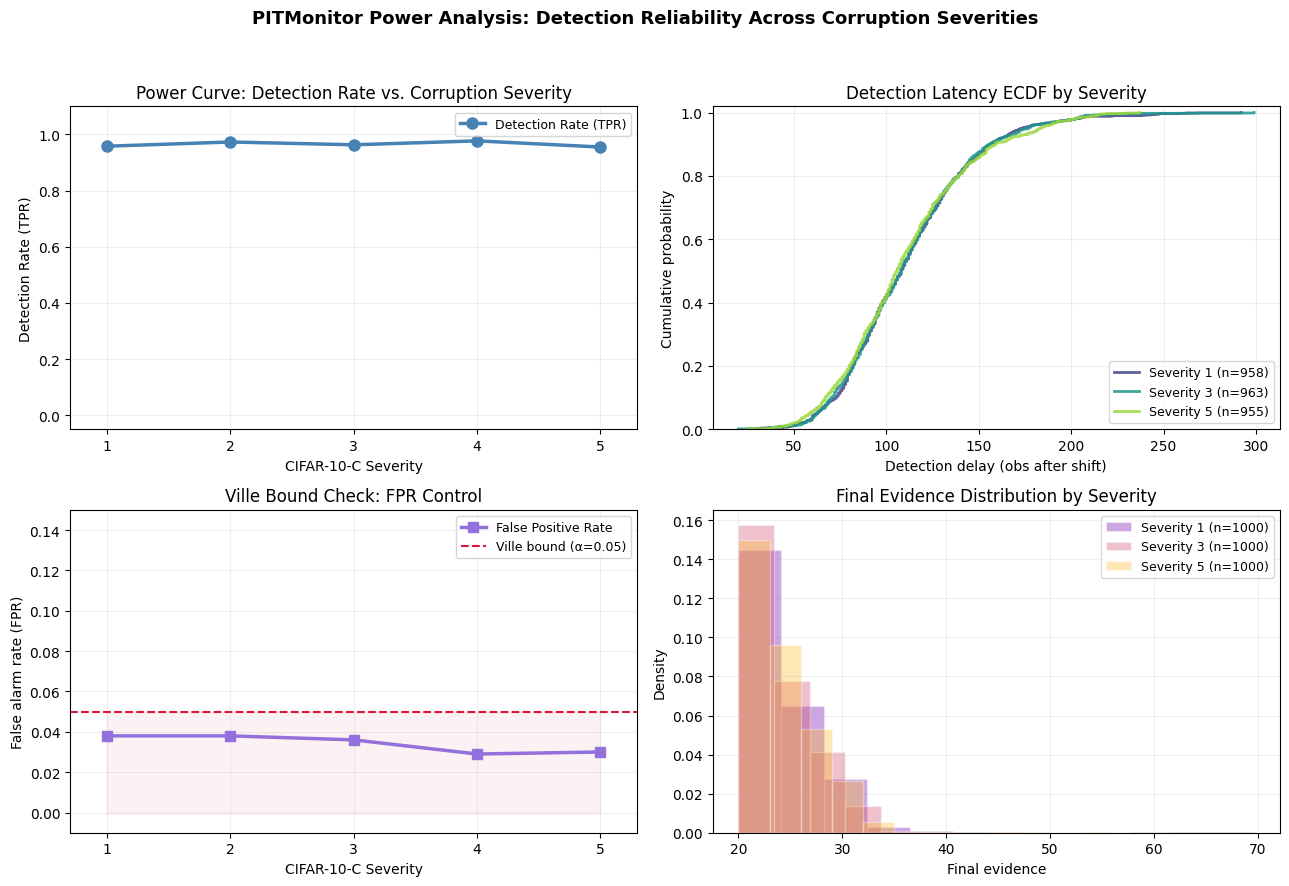

In [56]:
severity_list = list(SEVERITY_LEVELS)
h0_fprs = [h0_results_by_severity[sv]["false_alarm_rate"] for sv in SEVERITY_LEVELS]
h1_tprs = [power_results_by_severity[sv]["tpr"] for sv in SEVERITY_LEVELS]
h1_delays = [power_results_by_severity[sv]["median_delay"] for sv in SEVERITY_LEVELS]

fig2, axes2 = plt.subplots(2, 2, figsize=(13, 9))
fig2.suptitle(
    "PITMonitor Power Analysis: Detection Reliability Across Corruption Severities",
    fontsize=13,
    fontweight="bold",
    y=0.98,
)

# Panel 1: Power curve (H₁ TPR vs severity)
ax = axes2[0, 0]
ax.plot(
    severity_list,
    h1_tprs,
    "o-",
    color="steelblue",
    lw=2.5,
    markersize=8,
    label="Detection Rate (TPR)",
    zorder=3,
)
ax.set(
    xlabel="CIFAR-10-C Severity",
    ylabel="Detection Rate (TPR)",
    title="Power Curve: Detection Rate vs. Corruption Severity",
)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(min(severity_list) - 0.3, max(severity_list) + 0.3)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.2)

# Panel 2: Detection delay ECDF by severity
ax = axes2[0, 1]
selected_sev = [1, 3, 5]
colors_delay = plt.cm.viridis(np.linspace(0.2, 0.85, len(selected_sev)))

for severity_level, c in zip(selected_sev, colors_delay):
    if severity_level in power_results_by_severity:
        delays = np.asarray(
            power_results_by_severity[severity_level]["delays"], dtype=float
        )
        if delays.size > 0:
            delays_sorted = np.sort(delays)
            ecdf = np.arange(1, len(delays_sorted) + 1) / len(delays_sorted)
            ax.step(
                delays_sorted,
                ecdf,
                where="post",
                color=c,
                lw=2,
                alpha=0.85,
                label=f"Severity {severity_level} (n={len(delays)})",
            )

ax.set(
    xlabel="Detection delay (obs after shift)",
    ylabel="Cumulative probability",
    title="Detection Latency ECDF by Severity",
)
ax.set_ylim(0.0, 1.02)
ax.legend(fontsize=9, loc="lower right")
ax.grid(True, alpha=0.2)

# Panel 3: H₀ FPR control (Ville bound)
ax = axes2[1, 0]
ax.plot(
    severity_list,
    h0_fprs,
    "s-",
    color="mediumpurple",
    lw=2.5,
    markersize=7,
    zorder=3,
    label="False Positive Rate",
)
ax.axhline(
    ALPHA_POWER,
    color="crimson",
    ls="--",
    lw=1.5,
    label=f"Ville bound (α={ALPHA_POWER:.2f})",
)
ax.fill_between(
    severity_list,
    0,
    [ALPHA_POWER] * len(severity_list),
    color="crimson",
    alpha=0.06,
)

ax.set(
    xlabel="CIFAR-10-C Severity",
    ylabel="False alarm rate (FPR)",
    title="Ville Bound Check: FPR Control",
)
ax.set_ylim(-0.01, min(0.15, ALPHA_POWER * 3.0))
ax.set_xlim(min(severity_list) - 0.3, max(severity_list) + 0.3)
ax.legend(fontsize=9, loc="upper right")
ax.grid(True, alpha=0.2)

# Panel 4: Final evidence distribution by severity
ax = axes2[1, 1]
selected_ev_sev = [1, 3, 5]
colors_ev = plt.cm.plasma(np.linspace(0.2, 0.85, len(selected_ev_sev)))

for severity_level, c in zip(selected_ev_sev, colors_ev):
    if severity_level in power_results_by_severity:
        evidences = np.asarray(
            power_results_by_severity[severity_level]["evidences"], dtype=float
        )
        if evidences.size > 0:
            ax.hist(
                evidences,
                bins=12,
                density=True,
                alpha=0.35,
                color=c,
                edgecolor="white",
                label=f"Severity {severity_level} (n={len(evidences)})",
            )

ax.set(
    xlabel="Final evidence",
    ylabel="Density",
    title="Final Evidence Distribution by Severity",
)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Part 3: Comparison to PITMonitor

> Baseline convention: every method is evaluated **relative to PITMonitor** (not against each other).

This section compares **PITMonitor** against four classical stream-drift detectors on the same CIFAR stream setup (clean → corrupted).

- **DDM (Drift Detection Method):** detects drift by monitoring the model's error rate over time. When the error rate passes a set threshold, it enters a warning phase, and if it passes another threshold, it enters a drift phase.
- **EDDM (Early Drift Detection Method):** improves DDM's detection rate by tracking the average distance between two errors instead of only the error rate.
- **ADWIN (Adaptive Windowing):** dynamically stores a window of recent data and warns the user if it detects a significant change between the statistics of the window's earlier data compared to more recent data.
- **KSWIN (Kolmogorov–Smirnov Windowing):** detects drift based on the Kolmogorov-Smirnov statistical test.

We report absolute metrics for PITMonitor and, for each baseline detector, both absolute metrics and deltas versus PITMonitor.

In [60]:
from collections import defaultdict
from dataclasses import dataclass

from river.drift import ADWIN, KSWIN
from river.drift.binary import DDM, EDDM


@dataclass
class BaselineRun:
    warning_time: int | None
    alarm_time: int | None
    false_alarm: bool
    detection_delay: int | None


def _make_river_detector(detector_name: str):
    if detector_name == "DDM":
        return DDM()
    if detector_name == "EDDM":
        return EDDM()
    if detector_name == "ADWIN":
        return ADWIN()
    if detector_name == "KSWIN":
        return KSWIN()
    raise ValueError(f"Unknown detector: {detector_name}")


def run_river_detectors_batch(
    detector_names: list[str], stream: np.ndarray, n_stable: int
) -> dict[str, BaselineRun]:
    """Run multiple river detectors in one pass over the same stream."""
    detectors = {name: _make_river_detector(name) for name in detector_names}
    warning_times = {name: None for name in detector_names}
    alarm_times = {name: None for name in detector_names}

    stream_arr = np.asarray(stream, dtype=np.float32)
    for t, value in enumerate(stream_arr, start=1):
        for name, detector in detectors.items():
            if alarm_times[name] is not None:
                continue

            detector.update(float(value))

            if warning_times[name] is None and bool(
                getattr(detector, "warning_detected", False)
            ):
                warning_times[name] = t
            if bool(getattr(detector, "drift_detected", False)):
                alarm_times[name] = t

    runs = {}
    for name in detector_names:
        alarm_time = alarm_times[name]
        false_alarm = alarm_time is not None and alarm_time <= n_stable
        delay = (
            alarm_time - n_stable
            if alarm_time is not None and alarm_time > n_stable
            else None
        )
        runs[name] = BaselineRun(warning_times[name], alarm_time, false_alarm, delay)

    return runs


def run_river_detector(
    detector_name: str, stream: np.ndarray, n_stable: int
) -> BaselineRun:
    """Backward-compatible single-detector wrapper."""
    return run_river_detectors_batch([detector_name], stream, n_stable)[detector_name]


def summarize_detector_trials(rows: list[dict]) -> dict:
    n = len(rows)
    n_alarm = sum(r["alarm_fired"] for r in rows)
    n_false = sum(r["false_alarm"] for r in rows)
    n_detect = sum(1 for r in rows if r["alarm_fired"] and not r["false_alarm"])
    delays = [r["detection_delay"] for r in rows if r["detection_delay"] is not None]
    return {
        "alarm_rate": n_alarm / n if n else float("nan"),
        "false_alarm_rate": n_false / n if n else float("nan"),
        "tpr": n_detect / n if n else float("nan"),
        "median_delay": float(np.median(delays)) if delays else float("nan"),
    }

In [62]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

COMPARE_METHODS = ["PITMonitor", "DDM", "EDDM", "ADWIN", "KSWIN"]
COMPARE_BASELINES = ["DDM", "EDDM", "ADWIN", "KSWIN"]
COMPARE_SEVERITIES = [1, 3, 5]
N_TRIALS_COMPARE = 1_000

comparison_rows = []

log("Part 3: PITMonitor-centric comparison")
t0_cmp = timer.time()

MAX_WORKERS = min(8, max(1, (os.cpu_count() or 4) - 1))

# Reuse Part 2 cache when available to avoid recomputing inference and PITMonitor trials.
cache_ready = (
    "shared_h1_trial_cache" in globals()
    and "shared_trial_cache_meta" in globals()
    and isinstance(shared_h1_trial_cache, dict)
    and all(sev in shared_h1_trial_cache for sev in COMPARE_SEVERITIES)
    and all(
        len(shared_h1_trial_cache[sev]) >= N_TRIALS_COMPARE
        for sev in COMPARE_SEVERITIES
    )
    and shared_trial_cache_meta.get("corruption") == CORRUPTION
    and shared_trial_cache_meta.get("n_stable") == N_STABLE_POWER
    and shared_trial_cache_meta.get("n_shifted") == N_SHIFTED_POWER
)

if cache_ready:
    log("Using cached Part 2 H₁ trials for Part 3 (no repeated model inference).")

    for severity_level in COMPARE_SEVERITIES:
        method_trials = defaultdict(list)
        cached_trials = shared_h1_trial_cache[severity_level][:N_TRIALS_COMPARE]

        def run_cached_trial(trial: dict) -> dict[str, dict]:
            pit_trial = trial["pit_trial"]
            n_stable_local = int(trial["n_stable"])

            if "error_stream" in trial:
                error_stream = np.asarray(trial["error_stream"], dtype=np.float32)
            else:
                y_all = np.asarray(trial["y_all"], dtype=np.int64)
                pred_labels = np.asarray(trial["pred_labels"], dtype=np.int64)
                error_stream = (pred_labels != y_all).astype(np.float32, copy=False)

            det_runs = run_river_detectors_batch(
                COMPARE_BASELINES, error_stream, n_stable_local
            )

            out = {"PITMonitor": pit_trial}
            for detector_name in COMPARE_BASELINES:
                det_run = det_runs[detector_name]
                out[detector_name] = {
                    "alarm_fired": det_run.alarm_time is not None,
                    "false_alarm": det_run.false_alarm,
                    "detection_delay": det_run.detection_delay,
                }
            return out

        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
            futures = [ex.submit(run_cached_trial, trial) for trial in cached_trials]
            for fut in as_completed(futures):
                trial_out = fut.result()
                for method in COMPARE_METHODS:
                    method_trials[method].append(trial_out[method])

        for method in COMPARE_METHODS:
            stats = summarize_detector_trials(method_trials[method])
            comparison_rows.append(
                {
                    "severity": severity_level,
                    "method": method,
                    **stats,
                }
            )

        elapsed = timer.time() - t0_cmp
        log(f"Severity {severity_level}: completed [{elapsed:.1f}s]")

else:
    log("Part 2 cache not found/mismatched; recomputing Part 3 trials from scratch.")

    for severity_level in COMPARE_SEVERITIES:
        x_corr_cmp, y_corr_cmp = load_cifar10c_corruption(
            DATA_DIR, CORRUPTION, severity_level
        )
        y_corr_cmp = y_corr_cmp.astype(np.int64, copy=False)

        method_trials = defaultdict(list)

        def run_single_trial(trial_idx: int) -> dict[str, dict]:
            trial_rng = np.random.default_rng(
                200_000 + severity_level * 10_000 + trial_idx
            )
            stable_idx = trial_rng.choice(
                test_pool_idx, size=N_STABLE_POWER, replace=False
            )
            shifted_idx = trial_rng.choice(
                len(x_corr_cmp), size=N_SHIFTED_POWER, replace=False
            )

            x_stable_local = x_test[stable_idx]
            y_stable_local = y_test[stable_idx]
            x_shifted_local = x_corr_cmp[shifted_idx]
            y_shifted_local = y_corr_cmp[shifted_idx]

            x_all = np.vstack([x_stable_local, x_shifted_local]).astype(
                np.float32, copy=False
            )
            y_all = np.concatenate([y_stable_local, y_shifted_local]).astype(
                np.int64, copy=False
            )

            probs = predict_proba_safe(clf_h0, x_all, sc_h0).astype(
                np.float32, copy=False
            )
            pred_labels = probs.argmax(axis=1)
            error_stream = (pred_labels != y_all).astype(np.float32, copy=False)

            pits = confidence_pits_from_reference(
                probs,
                y_all,
                pit_cal_reference,
                np.random.default_rng(300_000 + severity_level * 10_000 + trial_idx),
            ).astype(np.float32, copy=False)

            monitor = PITMonitor(alpha=ALPHA_POWER, n_bins=N_BINS)
            monitor.update_many(pits, stop_on_alarm=True)
            pit_trial = monitor.trial_summary(len(y_stable_local))

            det_runs = run_river_detectors_batch(
                COMPARE_BASELINES, error_stream, len(y_stable_local)
            )

            out = {"PITMonitor": pit_trial}
            for detector_name in COMPARE_BASELINES:
                det_run = det_runs[detector_name]
                out[detector_name] = {
                    "alarm_fired": det_run.alarm_time is not None,
                    "false_alarm": det_run.false_alarm,
                    "detection_delay": det_run.detection_delay,
                }
            return out

        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
            futures = [
                ex.submit(run_single_trial, idx) for idx in range(N_TRIALS_COMPARE)
            ]
            for fut in as_completed(futures):
                trial_out = fut.result()
                for method in COMPARE_METHODS:
                    method_trials[method].append(trial_out[method])

        for method in COMPARE_METHODS:
            stats = summarize_detector_trials(method_trials[method])
            comparison_rows.append(
                {
                    "severity": severity_level,
                    "method": method,
                    **stats,
                }
            )

        elapsed = timer.time() - t0_cmp
        log(f"Severity {severity_level}: completed [{elapsed:.1f}s]")

pit_reference = {
    sev: next(
        r
        for r in comparison_rows
        if r["severity"] == sev and r["method"] == "PITMonitor"
    )
    for sev in COMPARE_SEVERITIES
}

print("PITMonitor baseline comparison by severity")
print(f"{'Severity':>8s}  {'Method':>10s}  {'FPR':>8s}  {'TPR':>8s}  {'Delay':>8s}")

for severity_level in COMPARE_SEVERITIES:
    pit_row = pit_reference[severity_level]
    print(
        f"{severity_level:>8d}  {'PITMonitor':>10s}  "
        f"{pit_row['false_alarm_rate']:>8.1%}  {pit_row['tpr']:>8.1%}  "
        f"{pit_row['median_delay']:>8.1f}"
    )
    for method in COMPARE_BASELINES:
        row = next(
            r
            for r in comparison_rows
            if r["severity"] == severity_level and r["method"] == method
        )
        print(
            f"{severity_level:>8d}  {method:>10s}  "
            f"{row['false_alarm_rate']:>8.1%}  {row['tpr']:>8.1%}  "
            f"{row['median_delay']:>8.1f}"
        )

Part 3: PITMonitor-centric comparison
Using cached Part 2 H₁ trials for Part 3 (no repeated model inference).
Severity 1: completed [87.3s]
Severity 3: completed [175.7s]
Severity 5: completed [261.7s]
PITMonitor baseline comparison by severity
Severity      Method       FPR       TPR     Delay
       1  PITMonitor      3.5%     96.5%     107.0
       1         DDM      4.8%     92.4%      71.0
       1        EDDM     85.2%     14.8%      46.0
       1       ADWIN      0.0%    100.0%     116.0
       1       KSWIN      4.8%     45.0%      29.0
       3  PITMonitor      4.2%     95.7%     108.0
       3         DDM      3.5%     93.3%      72.0
       3        EDDM     84.0%     16.0%      52.5
       3       ADWIN      0.0%    100.0%     116.0
       3       KSWIN      5.8%     41.6%      29.5
       5  PITMonitor      3.3%     96.7%     106.0
       5         DDM      3.7%     94.3%      71.0
       5        EDDM     85.2%     14.8%      47.5
       5       ADWIN      0.0%    100.0% 

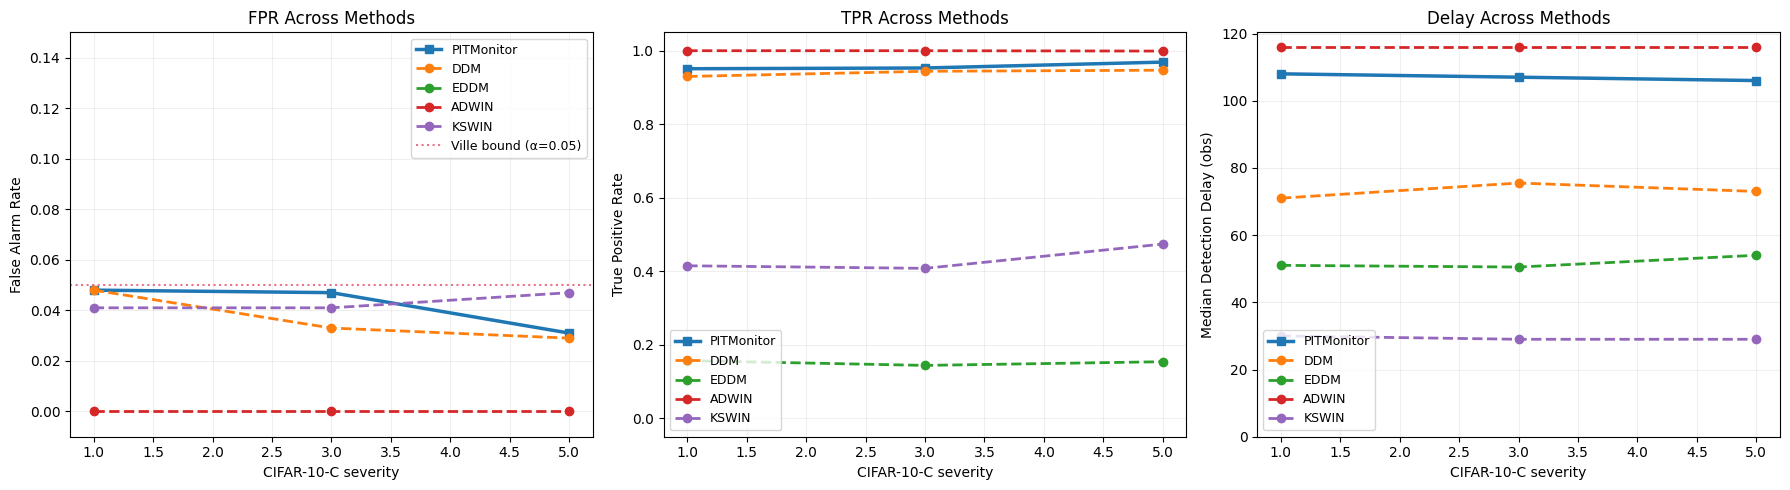

In [53]:
fig_cmp, axes_cmp = plt.subplots(1, 3, figsize=(18, 5))

# Collect data for all methods including PITMonitor
all_methods_plot = COMPARE_METHODS
xs = COMPARE_SEVERITIES

for method in all_methods_plot:
    ys_fpr = []
    ys_tpr = []
    ys_delay = []
    for sev in xs:
        row = next(
            r for r in comparison_rows if r["severity"] == sev and r["method"] == method
        )
        ys_fpr.append(row["false_alarm_rate"])
        ys_tpr.append(row["tpr"])
        ys_delay.append(row["median_delay"])

    linestyle = "-" if method == "PITMonitor" else "--"
    marker = "s" if method == "PITMonitor" else "o"
    linewidth = 2.5 if method == "PITMonitor" else 2

    axes_cmp[0].plot(
        xs, ys_fpr, marker=marker, lw=linewidth, ls=linestyle, label=method
    )
    axes_cmp[1].plot(
        xs, ys_tpr, marker=marker, lw=linewidth, ls=linestyle, label=method
    )
    axes_cmp[2].plot(
        xs, ys_delay, marker=marker, lw=linewidth, ls=linestyle, label=method
    )

axes_cmp[0].axhline(
    ALPHA_POWER,
    color="crimson",
    ls=":",
    lw=1.5,
    label=f"Ville bound (α={ALPHA_POWER:.2f})",
    alpha=0.6,
)

axes_cmp[0].set(
    xlabel="CIFAR-10-C severity",
    ylabel="False Alarm Rate",
    title="FPR Across Methods",
)
axes_cmp[0].grid(True, alpha=0.2)
axes_cmp[0].legend(fontsize=9, loc="best")
axes_cmp[0].set_ylim(-0.01, 0.15)

axes_cmp[1].set(
    xlabel="CIFAR-10-C severity",
    ylabel="True Positive Rate",
    title="TPR Across Methods",
)
axes_cmp[1].grid(True, alpha=0.2)
axes_cmp[1].legend(fontsize=9, loc="best")
axes_cmp[1].set_ylim(-0.05, 1.05)

axes_cmp[2].set(
    xlabel="CIFAR-10-C severity",
    ylabel="Median Detection Delay (obs)",
    title="Delay Across Methods",
)
axes_cmp[2].grid(True, alpha=0.2)
axes_cmp[2].legend(fontsize=9, loc="best")
axes_cmp[2].set_ylim(bottom=0)

plt.tight_layout()
plt.show()